In [10]:
import os.path

import joblib
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

from lime.lime_tabular import LimeTabularExplainer
from lime.metrics import jaccard_similarities

# 1. Dataset preparation
### 1.1 Define data

In [11]:
# Determine data paths

DATA_DIR = '..\data'
DATASET_DIR = 'sample_dataset_1'
MODELS_DIR = '..\model_checkpoints'

CATEGORICAL_FEATURES = ["Dst Port", 'Timestamp', 'Label', 'Protocol', 'Fwd PSH Flags', 'FIN Flag Cnt', 'SYN Flag Cnt',
                        'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'ECE Flag Cnt',
                        'Fwd Seg Size Min']

# TODO Dropping these categorical features for now, need to handle them later. Leaving only binary categorical features.
COLUMNS_TO_DROP = [
    'Timestamp',  # Needs a way for enncoding (time of day?)
    'Dst Port',
    # Categories: [53, 80, 22, 21, 3389, 64458, 443, 50158, 445, 50243, 49730, 51240, 0, 55146, 49942, 50197, 41096, 51579, 49154, 54429, 52737, 49948, 50574, 52147, 49681, 10884, 56754, 44285, 50667, 5355, 50576, 51311, 51090, 63467, 55232, 50633, 50516, 50122, 50746, 51740, 30158, 51902, 49713, 50227, 137, 54698, 49615, 51189, 52165, 50865, 13056, 49552, 51182, 21462, 49480, 49739, 51392, 25603, 49867, 49886, 60827, 51966, 54706, 49870, 50900, 52013, 50608, 50228, 51324, 51445, 50074, 2046, 50073, 55189, 63979, 50376, 38872, 4899, 49995, 50593, 62410]
    'Protocol',  # Categories: [17, 6, 0] (one-hot ?)
    'Fwd Seg Size Min'  # Categories: [8, 20, 32, 40, 0, 28] (one-hot ?)
]
CATEGORICAL_FEATURES = [col for col in CATEGORICAL_FEATURES if col not in COLUMNS_TO_DROP]
# TODO now dropping rows with infinity values, need to handle them later

train_data_path = os.path.join(DATA_DIR, DATASET_DIR, 'train_data.csv')
val_data_path = os.path.join(DATA_DIR, DATASET_DIR, 'val_data.csv')
test_data_path = os.path.join(DATA_DIR, DATASET_DIR, 'test_data.csv')

### 1. 2 Load data and encode labels

In [12]:
# Load dataset
train_data = pd.read_csv(train_data_path).drop(columns=COLUMNS_TO_DROP)
val_data = pd.read_csv(val_data_path).drop(columns=COLUMNS_TO_DROP)
test_data = pd.read_csv(test_data_path).drop(columns=COLUMNS_TO_DROP)


# Drop rows with infinity values
def drop_infinity_rows(df):
    return df[~df.isin([np.inf, -np.inf]).any(axis=1)]


# Apply the function to each dataset
train_data = drop_infinity_rows(train_data)
val_data = drop_infinity_rows(val_data)
test_data = drop_infinity_rows(test_data)

# Split features and labels
train_x, train_y = train_data.iloc[:, :-1], train_data.iloc[:, -1]
val_x, val_y = val_data.iloc[:, :-1], val_data.iloc[:, -1]
test_x, test_y = test_data.iloc[:, :-1], test_data.iloc[:, -1]

# Setup encoder for labels
label_encoder = LabelEncoder()
label_encoder.fit(pd.concat([train_y, val_y, test_y]))
class_names = label_encoder.classes_

# Encode labels
train_y = label_encoder.transform(train_y)
val_y = label_encoder.transform(val_y)
test_y = label_encoder.transform(test_y)

# Turn to numpy arrays
train_x_np = train_x.to_numpy()
val_x_np = val_x.to_numpy()
test_x_np = test_x.to_numpy()

print("Created dataset (train, val, test):", train_x.shape, val_x.shape, test_x.shape)
print("Y labels:", class_names)

Created dataset (train, val, test): (697, 65) (149, 65) (148, 65)
Y labels: ['Benign' 'FTP-BruteForce' 'SSH-Bruteforce']


### 1.3 Check feature information

In [13]:
# Feature names
feature_names = train_x.columns

# Categorical features information extraction
categorical_columns_dict = {
    train_x.columns.get_loc(col): train_x[col].unique().tolist()
    for col in CATEGORICAL_FEATURES if col in train_x
}

continuous_columns = [col for col in train_x.columns if col not in CATEGORICAL_FEATURES]

# Feature summary
print(f"Total number of features: {len(train_x.columns)}\n")

# Categorical columns with their indices, names, and categories
print(f"Categorical columns ({len(categorical_columns_dict)}):")
for col_index, categories in categorical_columns_dict.items():
    col_name = train_x.columns[int(col_index)]  # Ensure col_index is treated as integer
    print(f"  - Index: {col_index}, Name: {col_name}, Categories: {categories}")

# Continuous columns with their indices and names
print(f"\nContinuous columns ({len(continuous_columns)}):")
for col in continuous_columns:
    col_index = train_x.columns.get_loc(col)
    print(f"  - Index: {col_index}, Name: {col}")


Total number of features: 65

Categorical columns (8):
  - Index: 29, Name: Fwd PSH Flags, Categories: [0, 1]
  - Index: 39, Name: FIN Flag Cnt, Categories: [0, 1]
  - Index: 40, Name: SYN Flag Cnt, Categories: [0, 1]
  - Index: 41, Name: RST Flag Cnt, Categories: [0, 1]
  - Index: 42, Name: PSH Flag Cnt, Categories: [0, 1]
  - Index: 43, Name: ACK Flag Cnt, Categories: [0, 1]
  - Index: 44, Name: URG Flag Cnt, Categories: [0, 1]
  - Index: 45, Name: ECE Flag Cnt, Categories: [0, 1]

Continuous columns (57):
  - Index: 0, Name: Flow Duration
  - Index: 1, Name: Tot Fwd Pkts
  - Index: 2, Name: Tot Bwd Pkts
  - Index: 3, Name: TotLen Fwd Pkts
  - Index: 4, Name: TotLen Bwd Pkts
  - Index: 5, Name: Fwd Pkt Len Max
  - Index: 6, Name: Fwd Pkt Len Min
  - Index: 7, Name: Fwd Pkt Len Mean
  - Index: 8, Name: Fwd Pkt Len Std
  - Index: 9, Name: Bwd Pkt Len Max
  - Index: 10, Name: Bwd Pkt Len Min
  - Index: 11, Name: Bwd Pkt Len Mean
  - Index: 12, Name: Bwd Pkt Len Std
  - Index: 13, Name: 

Output: 
1. train, validation, and test data (x: train_x, val_x, test_x), their encoded labels(y)
2. feature information - categorical features and their categories, all features names, label names.

# 2. Model training

### 2.1 Random Forest Classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier


class RandomForestModel:
    def __init__(self, n_estimators, random_state, max_depth, max_features):
        self.model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state, max_depth=max_depth,
                                            max_features=max_features)

    def train(self, train_x, train_y):
        self.model.fit(train_x, train_y)

    def evaluate(self, test_x, test_y):
        accuracy = self.model.score(test_x, test_y)
        print("Test accuracy:", accuracy)
        return accuracy

    def save(self, path):
        joblib.dump(self.model, path)

    def load(self, path):
        self.model = joblib.load(path)

In [15]:
rf_model = RandomForestModel(n_estimators=10, random_state=0, max_depth=5, max_features=5)

# Load model if exists, train and save otherwise
checkpoint_dir = f'{MODELS_DIR}/{DATASET_DIR}_rf.pkl'

if os.path.exists(checkpoint_dir):
    rf_model.load(checkpoint_dir)
else:
    rf_model.train(train_x_np, train_y)
    rf_model.evaluate(val_x_np, val_y)
    rf_model.save(checkpoint_dir)

model_to_explain = rf_model.model

Output: a trained model

# 3. Model explanation

In [16]:
# Define explainability configuration

experiment_configuration = {
    "dataset": DATASET_DIR,
    "number_of_features": len(train_x.columns),
    "number_of_categorical_features": len(categorical_columns_dict),
    "number_of_continuous_features": len(continuous_columns),
    "model": 'RandomForest',
    "times_explained": 20,
    "kernel_width": None,
    "kernel": None,
    "verbose": False,
    "feature_selection": 'auto',
    "sample_around_instance": False,
    "num_features": 10,
    "num_samples": 5000,
    "distance_metric": 'euclidean',
    "model_regresor": None,
    "sampling_method": 'gaussian'
}

# Define test instance
random_test_index = np.random.randint(0, test_x_np.shape[0])
test_x_sample = test_x_np[random_test_index]
test_y_sample = test_y[random_test_index]

,dataset,number_of_features,number_of_categorical_features,number_of_continuous_features,model,times_explained,kernel_width,kernel,verbose,feature_selection,sample_around_instance,num_features,num_samples,distance_metric,model_regresor,sampling_method,Stability Benign,Stability FTP-BruteForce,Stability SSH-Bruteforce
0,sample_dataset_1,65,8,57,RandomForest,20,None,None,False,auto,False,10,5000,euclidean,None,gaussian,0.702947,0.818415,0.750664


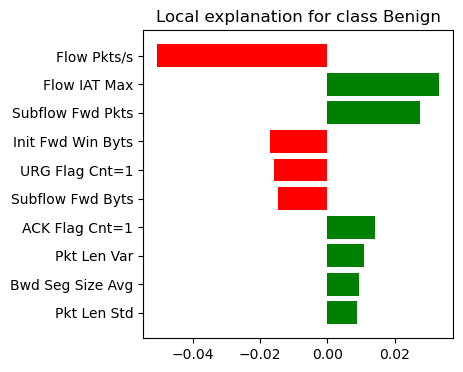

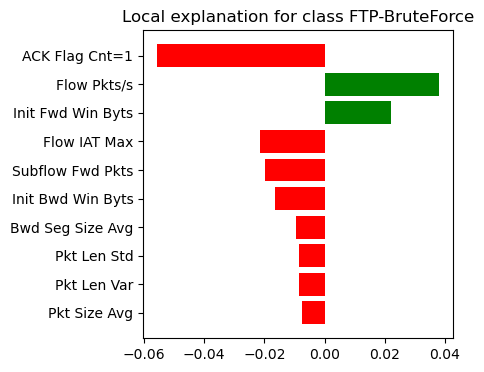

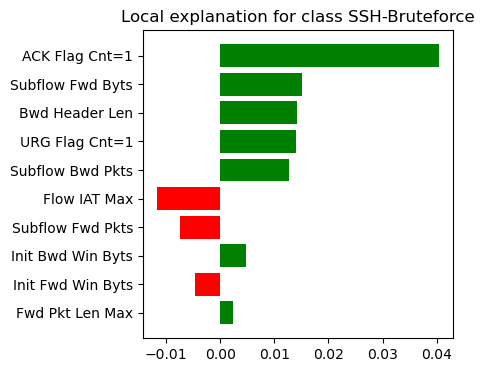

In [17]:
# Load explainer

categorical_features = list(categorical_columns_dict.keys())

explainer = LimeTabularExplainer(
    training_data=train_x_np,
    mode="classification",
    feature_names=feature_names,
    categorical_features=categorical_columns_dict.keys(),
    categorical_names=categorical_columns_dict,
    class_names=class_names,
    kernel_width=experiment_configuration['kernel_width'],
    kernel=experiment_configuration['kernel'],
    verbose=experiment_configuration['verbose'],
    feature_selection=experiment_configuration['feature_selection'],
    sample_around_instance=experiment_configuration['sample_around_instance'],
    random_state=None
)

experiment_results = {label: [] for label in class_names}

# Explain the same instance multiple times
for i in range(experiment_configuration["times_explained"]):
    exp = explainer.explain_instance(
        data_row=test_x_sample,
        predict_fn=model_to_explain.predict_proba,
        top_labels=len(class_names),  # number of labels to explain. Explaining all
        num_features=experiment_configuration["num_features"],  # maximum number of features present in explanation
        num_samples=experiment_configuration["num_samples"],  # size of the neighborhood to learn the linear model
        distance_metric=experiment_configuration["distance_metric"],  # the distance metric to use for weights.
        model_regressor=experiment_configuration["model_regresor"],
        # surrogate model / defaults to Ridge regression in LimeBase
        sampling_method=experiment_configuration['sampling_method']  # Method to sample synthetic data
    )

    # Append explanation to the corresponding label
    for label_index, label in enumerate(class_names):
        experiment_results[label].append(exp.as_list(label_index))

# Show last explanation
for label_index, label in enumerate(class_names):
    exp.as_pyplot_figure(label_index)

# Calculate stability of explanations
stability_results = {}
for label in class_names:
    explanations = experiment_results[label]
    explanations_features = [[f[0] for f in exp] for exp in explanations]
    sim = jaccard_similarities(explanations_features)
    stability_results["Stability " + label] = np.asarray(sim).mean()

results_dict = {}
results_dict.update(experiment_configuration)
results_dict.update(stability_results)

results = pd.DataFrame(results_dict, index=[0])
results.to_csv(f'results.csv', index=False)

results